<a href="https://colab.research.google.com/github/AnggitaGayatri/COBA-COBA/blob/Anggita-dev/Prediksi_Saham_LQ45_per_emiten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import math
import random

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import scipy.stats as stats
%matplotlib inline
from itertools import cycle

# Konfigurasi Visualisasi
pio.templates.default = "plotly_dark"
%config InlineBackend.figure_format = 'retina'

#preprocessing
from sklearn.preprocessing import MinMaxScaler

# membangun model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping


# Untuk evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

# **MODEL1**

## LOAD DATA

In [ ]:
model1_data = pd.read_excel("dataset_lq45_intraday.xlsx", sheet_name="SRTG.JK")

In [ ]:
model1_data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-10-03 09:00:00,2660,2690,2630,2640,2640,0
1,2022-10-03 10:00:00,2630,2670,2620,2650,2650,2501800
2,2022-10-03 11:00:00,2650,2670,2650,2660,2660,644200
3,2022-10-03 13:00:00,2660,2670,2650,2660,2660,589200
4,2022-10-03 14:00:00,2660,2660,2620,2640,2640,2296200


## Preprocessing

check null values

In [ ]:
model1_data.isna().sum()

,0
Datetime,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


cek jumlah baris dan kolom

In [ ]:
print('Jumlah total baris yang ada dalam dataset: ', model1_data.shape[0])
print('Jumlah total kolom yang ada dalam dataset: ', model1_data.shape[1])

Jumlah total baris yang ada dalam dataset:  3152
Jumlah total kolom yang ada dalam dataset:  7


In [ ]:
model1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   3152 non-null   datetime64[ns]
 1   Open       3152 non-null   int64         
 2   High       3152 non-null   int64         
 3   Low        3152 non-null   int64         
 4   Close      3152 non-null   int64         
 5   Adj Close  3152 non-null   int64         
 6   Volume     3152 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 172.5 KB


In [ ]:
start_date = model1_data['Datetime'].min()
end_date = model1_data['Datetime'].max()

print('Tanggal mulai dari dataset: ', start_date)
print('Tanggal akhir dari dataset: ', end_date)

Tanggal mulai dari dataset:  2022-10-03 09:00:00
Tanggal akhir dari dataset:  2024-09-27 16:00:00


In [ ]:
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=model1_data['Datetime'],
    y=model1_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Whole period of timeframe of Bank BRI close price 2014-2024',
    xaxis_title='Date',
    yaxis_title='Close Stock',
    plot_bgcolor='black',  # Menyesuaikan warna latar belakang sesuai template dark
    font=dict(size=15, color='white')  # Menyesuaikan warna font sesuai template dark
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()

In [ ]:
filtered_data = model1_data[model1_data['Datetime'].dt.date == pd.to_datetime('2024-09-27').date()]

# Membuat plot untuk satu hari
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=filtered_data['Datetime'],
    y=filtered_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Close Price Bank BRI (1 January 2024)',
    xaxis_title='Time',
    yaxis_title='Close Stock',
    plot_bgcolor='black',
    font=dict(size=15, color='white')
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()


### Normalisasi Data

select features

In [ ]:
model1 =model1_data[['Close']]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
model1=scaler.fit_transform(np.array(model1).reshape(-1,1))
print(model1.shape)

(3152, 1)


In [ ]:
model1

array([[0.88643533],
       [0.89274448],
       [0.89905363],
       ...,
       [0.81072555],
       [0.83596215],
       [0.829653  ]])

### Slicing Training and Test Dataset

In [ ]:
training_size=int(len(model1)*0.80)
test_size=len(model1)-training_size
train_data,test_data=model1[0:training_size,:],model1[training_size:len(model1),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2521, 1)
test_data:  (631, 1)


### reshape array

set seed

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

time step

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 35
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2485, 35)
y_train:  (2485,)
X_test:  (595, 35)
y_test (595,)


reshape input to be [samples, time steps, features] which is required for LSTM


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2485, 35, 1)
X_test:  (595, 35, 1)


## Model Building

In [ ]:
model = Sequential()
model.add(Input(shape=(35, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
# Fit model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    )

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0552 - val_loss: 0.0018
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6501e-04 - val_loss: 0.0017
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2602e-04 - val_loss: 0.0016
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.0755e-04 - val_loss: 0.0016
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.9024e-04 - val_loss: 0.0015
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.7513e-04 - val_loss: 0.0014
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.6175e-04 - val_loss: 0.0013
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.4902e-04 - val_loss: 0.0012
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.3596e-04 - val_loss: 0.0012
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.2175e-04 - val_loss: 0.0011
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0636e-04 - val_loss: 0.0010
Epoch 12/150

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((2485, 1), (595, 1))

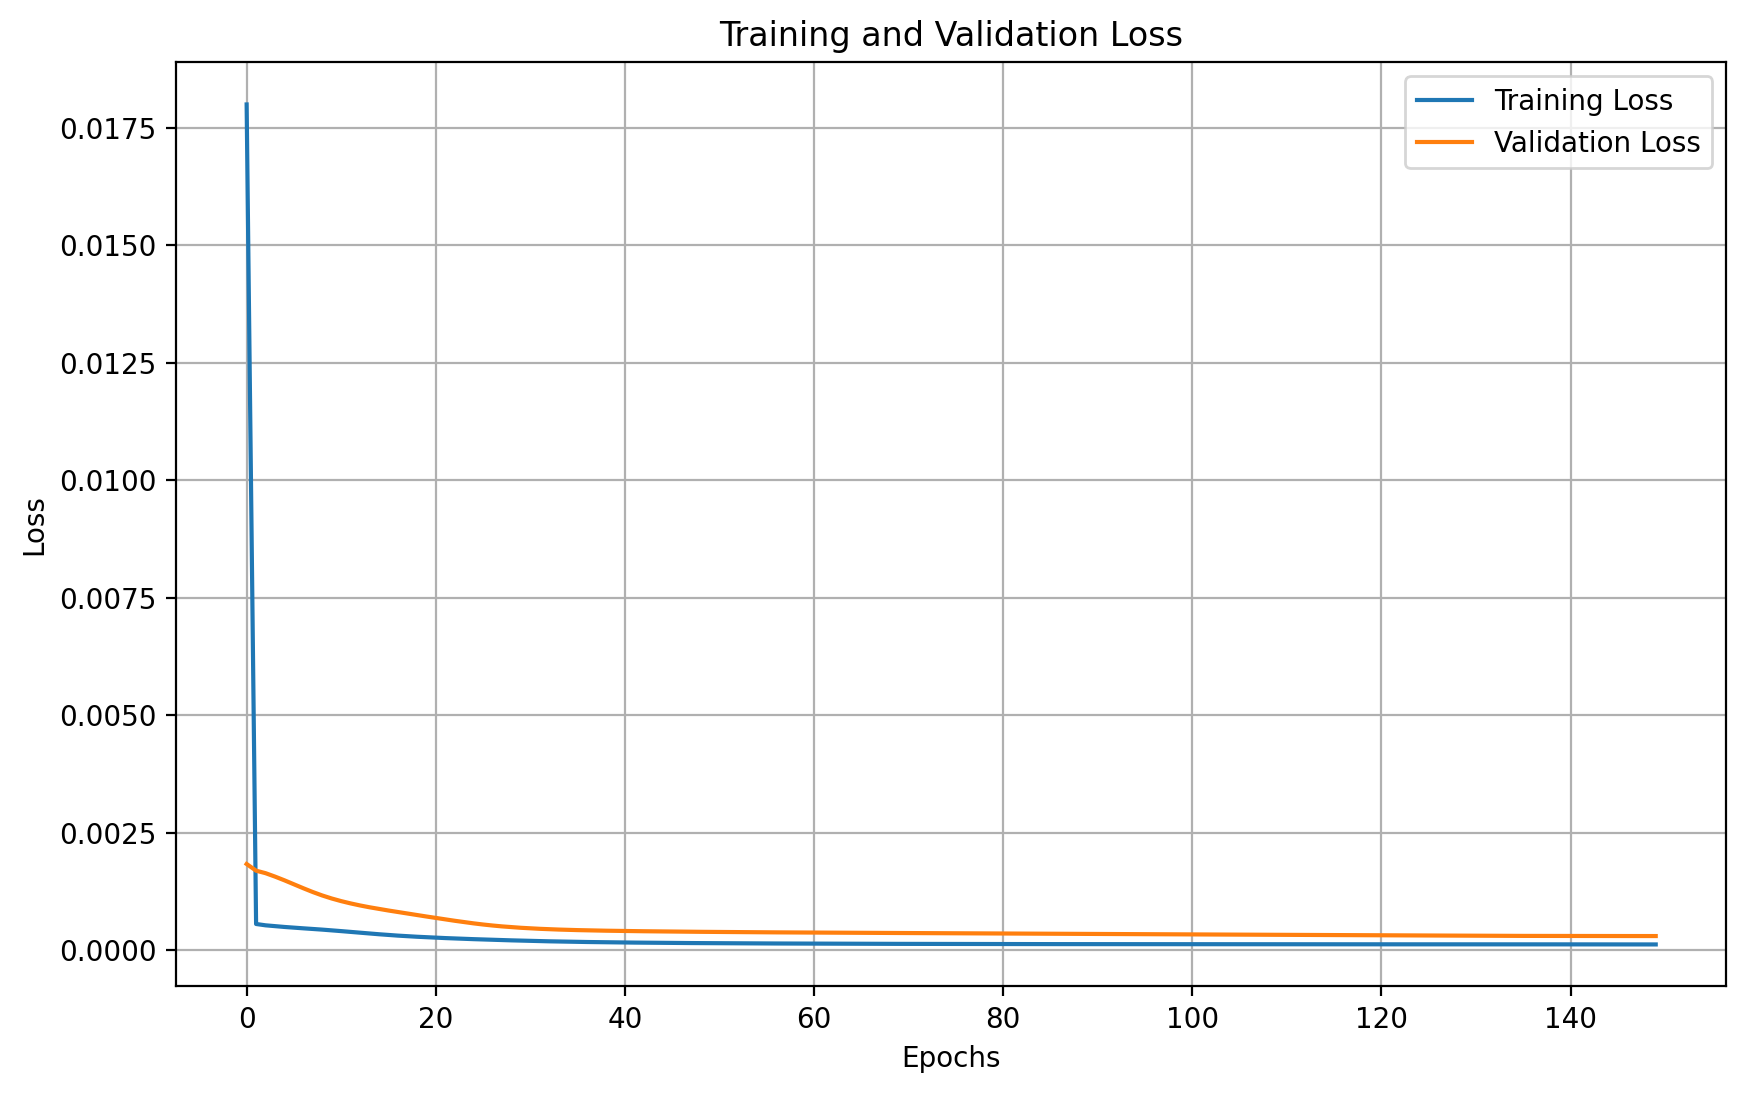

In [ ]:
import matplotlib.pyplot as plt

# Mengambil nilai loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### evaluasi

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Hitung RMSE
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predict))
test_rmse = np.sqrt(mean_squared_error(original_ytest, test_predict))

# Hitung MAPE
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict) * 100  # Mengalikan dengan 100
test_mape = mean_absolute_percentage_error(original_ytest, test_predict) * 100  # Mengalikan dengan 100

# Hitung R² (Koefisien Determinasi)
train_r2 = r2_score(original_ytrain, train_predict)
test_r2 = r2_score(original_ytest, test_predict)

# Cetak hasil evaluasi dengan dua angka di belakang koma
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))

print("Training MAPE (%): {:.4f}".format(train_mape))  # Menampilkan dalam persen
print("Testing MAPE (%): {:.4f}".format(test_mape))    # Menampilkan dalam persen


Training RMSE: 16.5761
Testing RMSE: 27.3431
Training MAPE (%): 0.6127
Testing MAPE (%): 0.8854


# **MODEL2**

## LOAD DATA

In [ ]:
model2_data = pd.read_excel("dataset_lq45_intraday.xlsx", sheet_name="TLKM.JK")

In [ ]:
model2_data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-10-03 09:00:00,4460,4470,4380,4440,4440,23685400
1,2022-10-03 10:00:00,4440,4450,4430,4450,4450,5504100
2,2022-10-03 11:00:00,4450,4450,4440,4440,4440,2345100
3,2022-10-03 13:00:00,4450,4450,4440,4440,4440,5259300
4,2022-10-03 14:00:00,4440,4470,4430,4470,4470,28754200


## Preprocessing

check null values

In [ ]:
model2_data.isna().sum()

,0
Datetime,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


cek jumlah baris dan kolom

In [ ]:
print('Jumlah total baris yang ada dalam dataset: ', model2_data.shape[0])
print('Jumlah total kolom yang ada dalam dataset: ', model2_data.shape[1])

Jumlah total baris yang ada dalam dataset:  3153
Jumlah total kolom yang ada dalam dataset:  7


In [ ]:
model2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3153 entries, 0 to 3152
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   3153 non-null   datetime64[ns]
 1   Open       3153 non-null   int64         
 2   High       3153 non-null   int64         
 3   Low        3153 non-null   int64         
 4   Close      3153 non-null   int64         
 5   Adj Close  3153 non-null   int64         
 6   Volume     3153 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 172.6 KB


In [ ]:
start_date = model2_data['Datetime'].min()
end_date = model2_data['Datetime'].max()

print('Tanggal mulai dari dataset: ', start_date)
print('Tanggal akhir dari dataset: ', end_date)

Tanggal mulai dari dataset:  2022-10-03 09:00:00
Tanggal akhir dari dataset:  2024-09-27 16:00:00


In [ ]:
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=model2_data['Datetime'],
    y=model2_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Whole period of timeframe of Bank BRI close price 2014-2024',
    xaxis_title='Date',
    yaxis_title='Close Stock',
    plot_bgcolor='black',  # Menyesuaikan warna latar belakang sesuai template dark
    font=dict(size=15, color='white')  # Menyesuaikan warna font sesuai template dark
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()

In [ ]:
filtered_data = model2_data[model2_data['Datetime'].dt.date == pd.to_datetime('2024-09-27').date()]

# Membuat plot untuk satu hari
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=filtered_data['Datetime'],
    y=filtered_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Close Price Bank BRI (1 January 2024)',
    xaxis_title='Time',
    yaxis_title='Close Stock',
    plot_bgcolor='black',
    font=dict(size=15, color='white')
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()


### Normalisasi Data

select features

In [ ]:
model2 =model2_data[['Close']]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
model2=scaler.fit_transform(np.array(model2).reshape(-1,1))
print(model2.shape)

(3153, 1)


In [ ]:
model2

array([[0.9558011 ],
       [0.96132597],
       [0.9558011 ],
       ...,
       [0.18232044],
       [0.1878453 ],
       [0.1878453 ]])

### Slicing Training and Test Dataset

In [ ]:
training_size=int(len(model2)*0.80)
test_size=len(model2)-training_size
train_data,test_data=model2[0:training_size,:],model2[training_size:len(model2),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2522, 1)
test_data:  (631, 1)


### reshape array

set seed

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

time step

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 35
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2486, 35)
y_train:  (2486,)
X_test:  (595, 35)
y_test (595,)


reshape input to be [samples, time steps, features] which is required for LSTM


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2486, 35, 1)
X_test:  (595, 35, 1)


## Model Building

In [ ]:
model = Sequential()
model.add(Input(shape=(35, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
# Fit model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    )

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1062 - val_loss: 0.0098
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.1894e-04 - val_loss: 0.0022
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.9257e-04 - val_loss: 0.0015
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.6860e-04 - val_loss: 0.0013
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.5441e-04 - val_loss: 0.0012
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.3923e-04 - val_loss: 0.0011
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.2559e-04 - val_loss: 9.8154e-04
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1249e-04 - val_loss: 9.1615e-04
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9846e-04 - val_loss: 8.6370e-04
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.8343e-04 - val_loss: 8.1668e-04


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((2486, 1), (595, 1))

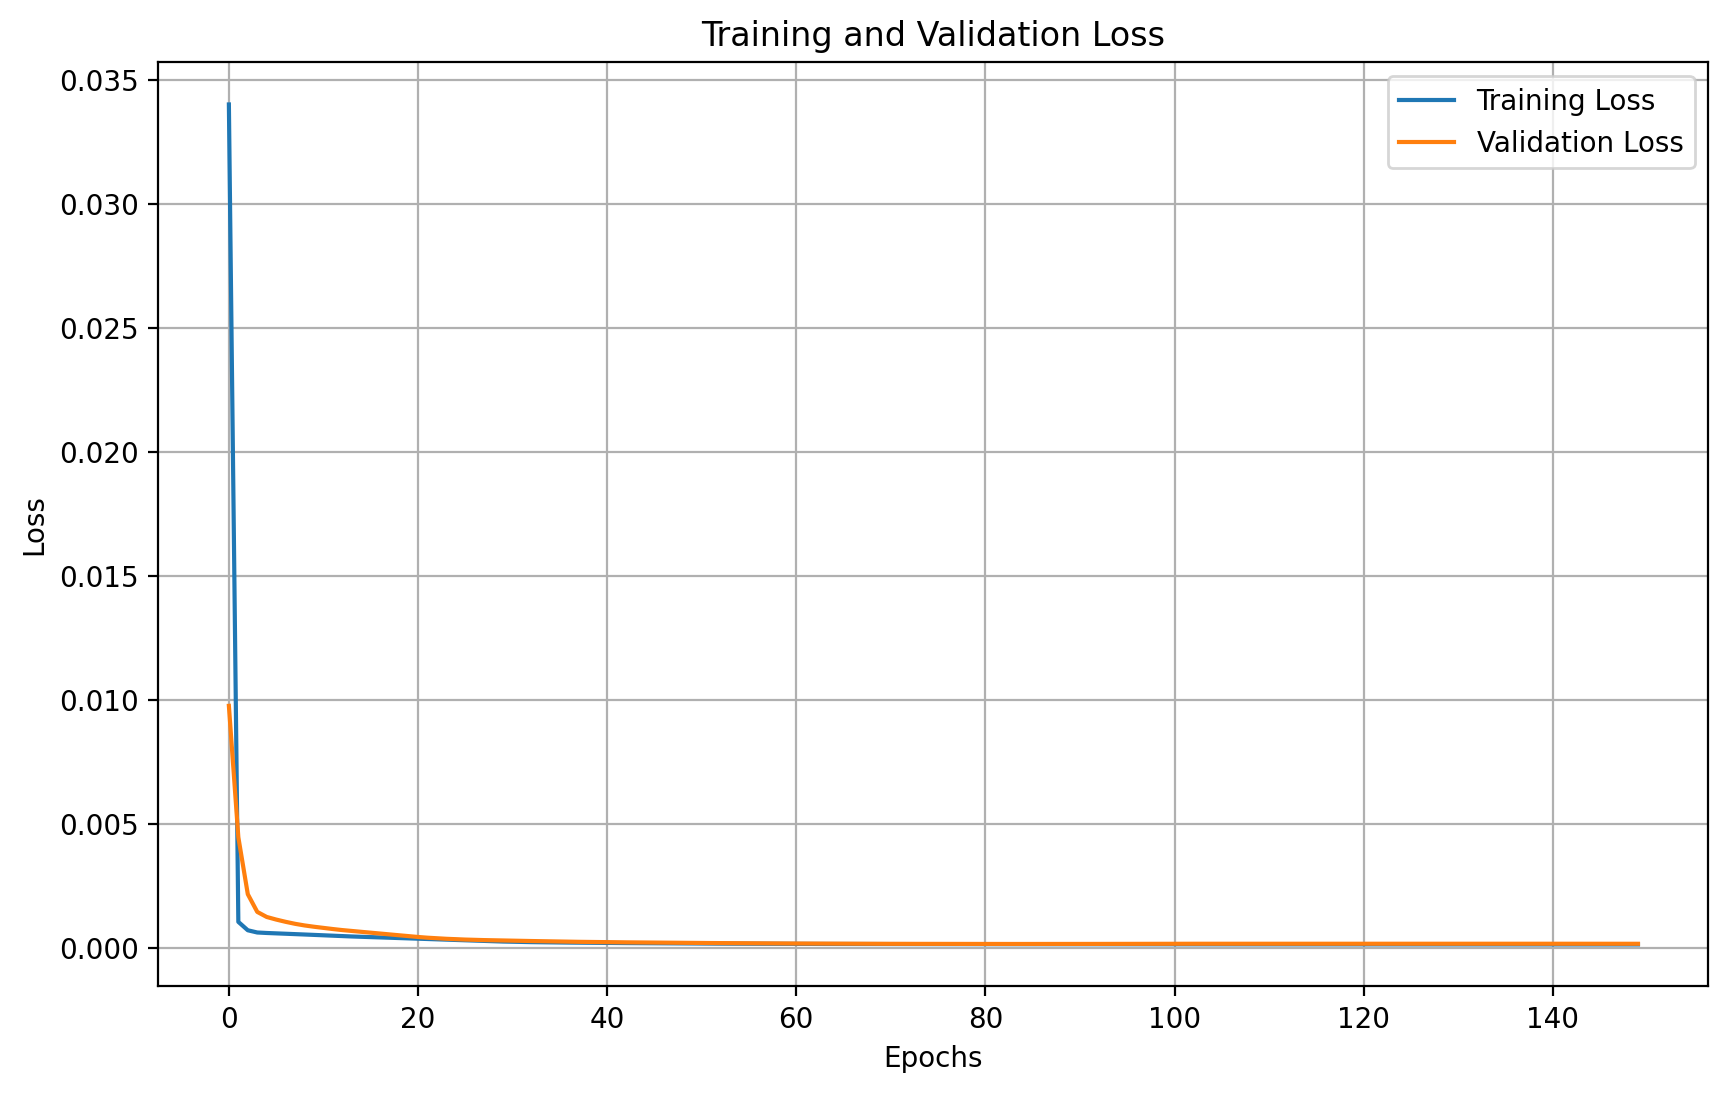

In [ ]:
import matplotlib.pyplot as plt

# Mengambil nilai loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### evaluasi

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Hitung RMSE
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predict))
test_rmse = np.sqrt(mean_squared_error(original_ytest, test_predict))

# Hitung MAPE
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict) * 100  # Mengalikan dengan 100
test_mape = mean_absolute_percentage_error(original_ytest, test_predict) * 100  # Mengalikan dengan 100

# Hitung R² (Koefisien Determinasi)
train_r2 = r2_score(original_ytrain, train_predict)
test_r2 = r2_score(original_ytest, test_predict)

# Cetak hasil evaluasi dengan dua angka di belakang koma
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))

print("Training MAPE (%): {:.4f}".format(train_mape))  # Menampilkan dalam persen
print("Testing MAPE (%): {:.4f}".format(test_mape))    # Menampilkan dalam persen


Training RMSE: 21.8340
Testing RMSE: 24.0852
Training MAPE (%): 0.3875
Testing MAPE (%): 0.5542


# **MODEL3**

## LOAD DATA

In [ ]:
model3_data = pd.read_excel("dataset_lq45_intraday.xlsx", sheet_name="TOWR.JK")

In [ ]:
model3_data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-10-03 09:00:00,1235,1240,1230,1240,1240,2545900
1,2022-10-03 10:00:00,1235,1240,1235,1235,1235,696100
2,2022-10-03 11:00:00,1235,1240,1235,1235,1235,513400
3,2022-10-03 13:00:00,1235,1235,1230,1230,1230,1236500
4,2022-10-03 14:00:00,1230,1235,1230,1235,1235,4396100


## Preprocessing

check null values

In [ ]:
model3_data.isna().sum()

,0
Datetime,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


cek jumlah baris dan kolom

In [ ]:
print('Jumlah total baris yang ada dalam dataset: ', model3_data.shape[0])
print('Jumlah total kolom yang ada dalam dataset: ', model3_data.shape[1])

Jumlah total baris yang ada dalam dataset:  3152
Jumlah total kolom yang ada dalam dataset:  7


In [ ]:
model3_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   3152 non-null   datetime64[ns]
 1   Open       3152 non-null   int64         
 2   High       3152 non-null   int64         
 3   Low        3152 non-null   int64         
 4   Close      3152 non-null   int64         
 5   Adj Close  3152 non-null   int64         
 6   Volume     3152 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 172.5 KB


In [ ]:
start_date = model3_data['Datetime'].min()
end_date = model3_data['Datetime'].max()

print('Tanggal mulai dari dataset: ', start_date)
print('Tanggal akhir dari dataset: ', end_date)

Tanggal mulai dari dataset:  2022-10-03 09:00:00
Tanggal akhir dari dataset:  2024-09-27 16:00:00


In [ ]:
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=model3_data['Datetime'],
    y=model3_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Whole period of timeframe of Bank BRI close price 2014-2024',
    xaxis_title='Date',
    yaxis_title='Close Stock',
    plot_bgcolor='black',  # Menyesuaikan warna latar belakang sesuai template dark
    font=dict(size=15, color='white')  # Menyesuaikan warna font sesuai template dark
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()

In [ ]:
filtered_data = model3_data[model3_data['Datetime'].dt.date == pd.to_datetime('2024-09-27').date()]

# Membuat plot untuk satu hari
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=filtered_data['Datetime'],
    y=filtered_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Close Price Bank BRI (1 January 2024)',
    xaxis_title='Time',
    yaxis_title='Close Stock',
    plot_bgcolor='black',
    font=dict(size=15, color='white')
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()


### Normalisasi Data

select features

In [ ]:
model3 =model3_data[['Close']]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
model3=scaler.fit_transform(np.array(model3).reshape(-1,1))
print(model3.shape)

(3152, 1)


In [ ]:
model3

array([[1.        ],
       [0.99122807],
       [0.99122807],
       ...,
       [0.33333333],
       [0.33333333],
       [0.3245614 ]])

### Slicing Training and Test Dataset

In [ ]:
training_size=int(len(model3)*0.80)
test_size=len(model3)-training_size
train_data,test_data=model3[0:training_size,:],model3[training_size:len(model3),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2521, 1)
test_data:  (631, 1)


### reshape array

set seed

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

time step

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 35
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2485, 35)
y_train:  (2485,)
X_test:  (595, 35)
y_test (595,)


reshape input to be [samples, time steps, features] which is required for LSTM


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2485, 35, 1)
X_test:  (595, 35, 1)


## Model Building

In [ ]:
model = Sequential()
model.add(Input(shape=(35, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
# Fit model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    )

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0898 - val_loss: 0.0058
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.2757e-04 - val_loss: 0.0011
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.9742e-04 - val_loss: 9.9927e-04
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.9391e-04 - val_loss: 9.0640e-04
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.8091e-04 - val_loss: 8.3248e-04
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.5978e-04 - val_loss: 7.6877e-04
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.3838e-04 - val_loss: 7.0999e-04
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.1958e-04 - val_loss: 6.5657e-04
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.0277e-04 - val_loss: 6.1002e-04
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.8712e-04 - val_l

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((2485, 1), (595, 1))

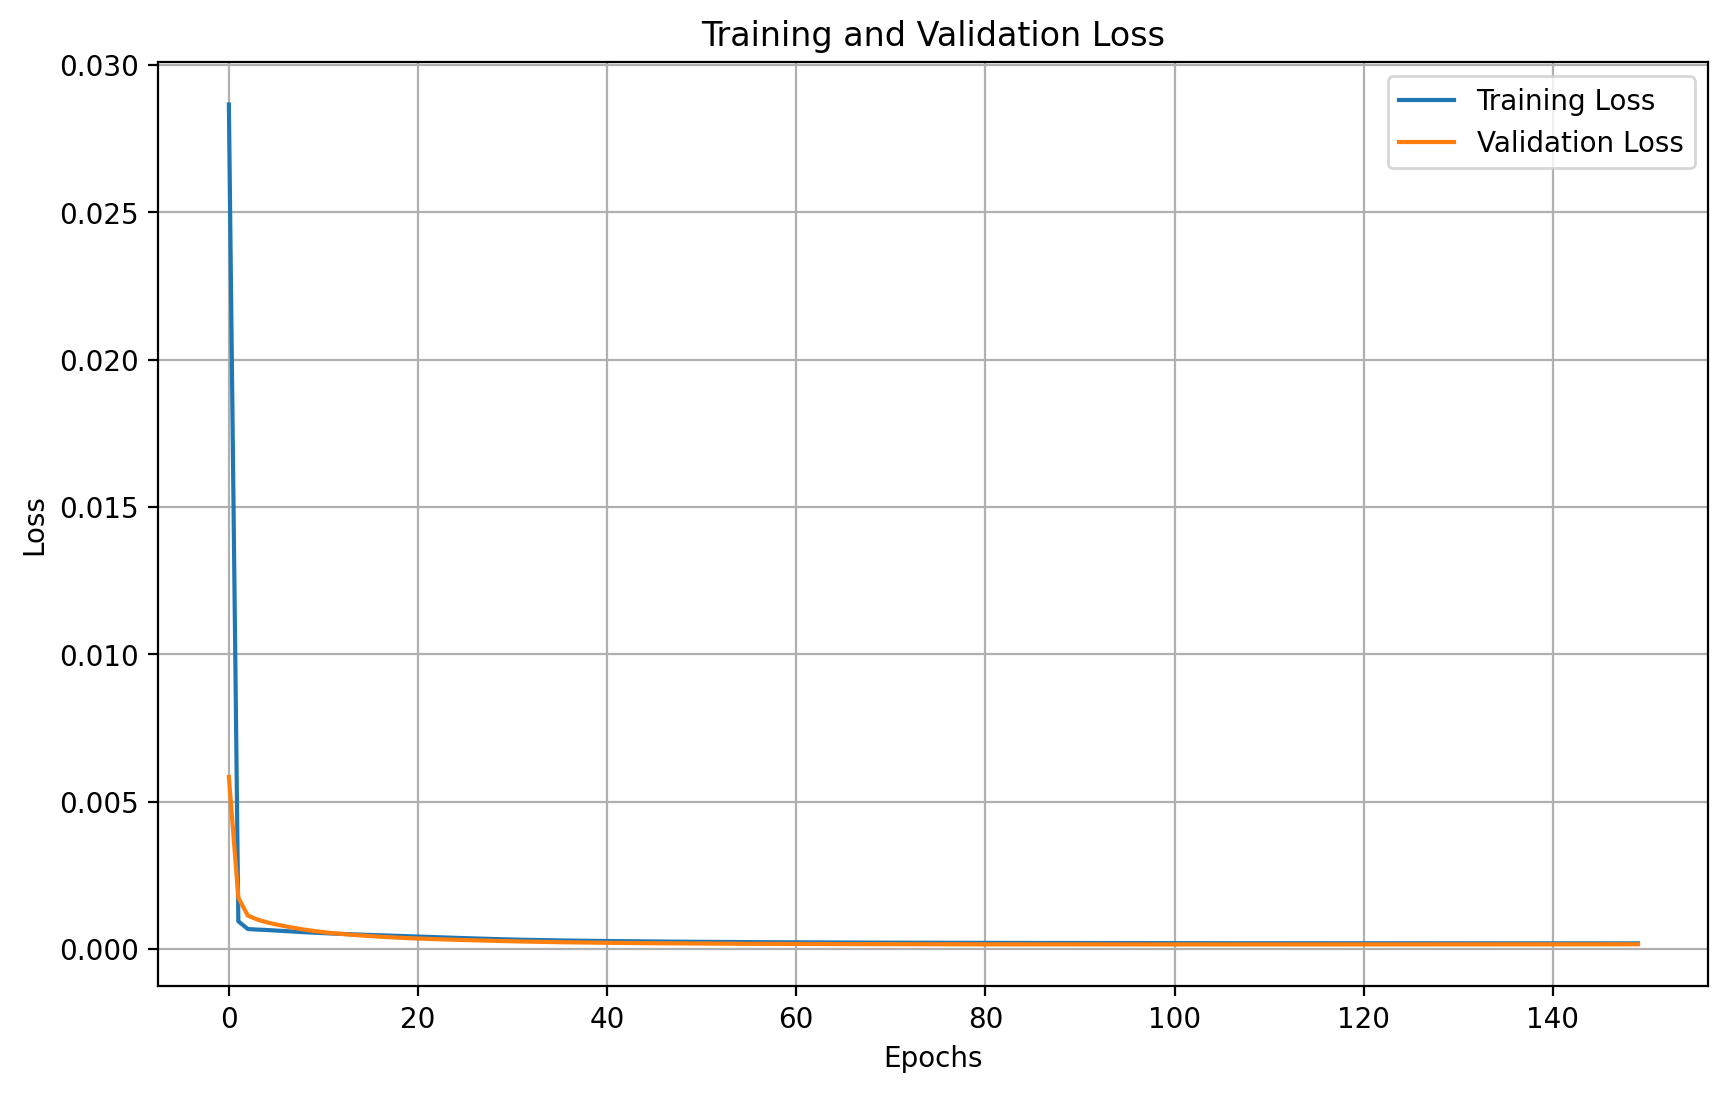

In [ ]:
import matplotlib.pyplot as plt

# Mengambil nilai loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### evaluasi

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Hitung RMSE
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predict))
test_rmse = np.sqrt(mean_squared_error(original_ytest, test_predict))

# Hitung MAPE
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict) * 100  # Mengalikan dengan 100
test_mape = mean_absolute_percentage_error(original_ytest, test_predict) * 100  # Mengalikan dengan 100

# Hitung R² (Koefisien Determinasi)
train_r2 = r2_score(original_ytrain, train_predict)
test_r2 = r2_score(original_ytest, test_predict)

# Cetak hasil evaluasi dengan dua angka di belakang koma
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))

print("Training MAPE (%): {:.4f}".format(train_mape))  # Menampilkan dalam persen
print("Testing MAPE (%): {:.4f}".format(test_mape))    # Menampilkan dalam persen


Training RMSE: 8.0222
Testing RMSE: 7.2256
Training MAPE (%): 0.6075
Testing MAPE (%): 0.6808


# **MODEL4**

## LOAD DATA

In [ ]:
model4_data = pd.read_excel("dataset_lq45_intraday.xlsx", sheet_name="UNTR.JK")

In [ ]:
model4_data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-10-03 09:00:00,32850,33200,32675,32900,32900,1693100
1,2022-10-03 10:00:00,32925,33025,32850,33000,33000,1036200
2,2022-10-03 11:00:00,33000,33000,32975,32975,32975,419600
3,2022-10-03 13:00:00,32975,33000,32925,32975,32975,642100
4,2022-10-03 14:00:00,32975,33125,32925,32975,32975,2617800


## Preprocessing

check null values

In [ ]:
model4_data.isna().sum()

,0
Datetime,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


cek jumlah baris dan kolom

In [ ]:
print('Jumlah total baris yang ada dalam dataset: ', model4_data.shape[0])
print('Jumlah total kolom yang ada dalam dataset: ', model4_data.shape[1])

Jumlah total baris yang ada dalam dataset:  3151
Jumlah total kolom yang ada dalam dataset:  7


In [ ]:
model4_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3151 entries, 0 to 3150
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   3151 non-null   datetime64[ns]
 1   Open       3151 non-null   int64         
 2   High       3151 non-null   int64         
 3   Low        3151 non-null   int64         
 4   Close      3151 non-null   int64         
 5   Adj Close  3151 non-null   int64         
 6   Volume     3151 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 172.4 KB


In [ ]:
start_date = model4_data['Datetime'].min()
end_date = model4_data['Datetime'].max()

print('Tanggal mulai dari dataset: ', start_date)
print('Tanggal akhir dari dataset: ', end_date)

Tanggal mulai dari dataset:  2022-10-03 09:00:00
Tanggal akhir dari dataset:  2024-09-27 16:00:00


In [ ]:
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=model1_data['Datetime'],
    y=model1_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Whole period of timeframe of Bank BRI close price 2014-2024',
    xaxis_title='Date',
    yaxis_title='Close Stock',
    plot_bgcolor='black',  # Menyesuaikan warna latar belakang sesuai template dark
    font=dict(size=15, color='white')  # Menyesuaikan warna font sesuai template dark
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()

In [ ]:
filtered_data = model4_data[model4_data['Datetime'].dt.date == pd.to_datetime('2024-09-27').date()]

# Membuat plot untuk satu hari
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=filtered_data['Datetime'],
    y=filtered_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Close Price Bank BRI (1 January 2024)',
    xaxis_title='Time',
    yaxis_title='Close Stock',
    plot_bgcolor='black',
    font=dict(size=15, color='white')
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()


### Normalisasi Data

select features

In [ ]:
model4 =model4_data[['Close']]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
model4=scaler.fit_transform(np.array(model4).reshape(-1,1))
print(model1.shape)

(3152, 1)


In [ ]:
model4

array([[0.91762452],
       [0.92528736],
       [0.92337165],
       ...,
       [0.50957854],
       [0.51149425],
       [0.51915709]])

### Slicing Training and Test Dataset

In [ ]:
training_size=int(len(model4)*0.80)
test_size=len(model4)-training_size
train_data,test_data=model4[0:training_size,:],model4[training_size:len(model4),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2520, 1)
test_data:  (631, 1)


### reshape array

set seed

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

time step

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 35
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2484, 35)
y_train:  (2484,)
X_test:  (595, 35)
y_test (595,)


reshape input to be [samples, time steps, features] which is required for LSTM


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2484, 35, 1)
X_test:  (595, 35, 1)


## Model Building

In [ ]:
model = Sequential()
model.add(Input(shape=(35, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
# Fit model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    )

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0514 - val_loss: 8.6115e-04
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012 - val_loss: 6.4809e-04
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 5.6895e-04
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.9755e-04 - val_loss: 5.0640e-04
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.9045e-04 - val_loss: 4.5354e-04
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.0134e-04 - val_loss: 4.1303e-04
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.3571e-04 - val_loss: 3.8367e-04
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8605e-04 - val_loss: 3.6073e-04
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.4463e-04 - val_loss: 3.4063e-04
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0935e-04 - val_loss: 3.2221e-04
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.7902e-04

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((2484, 1), (595, 1))

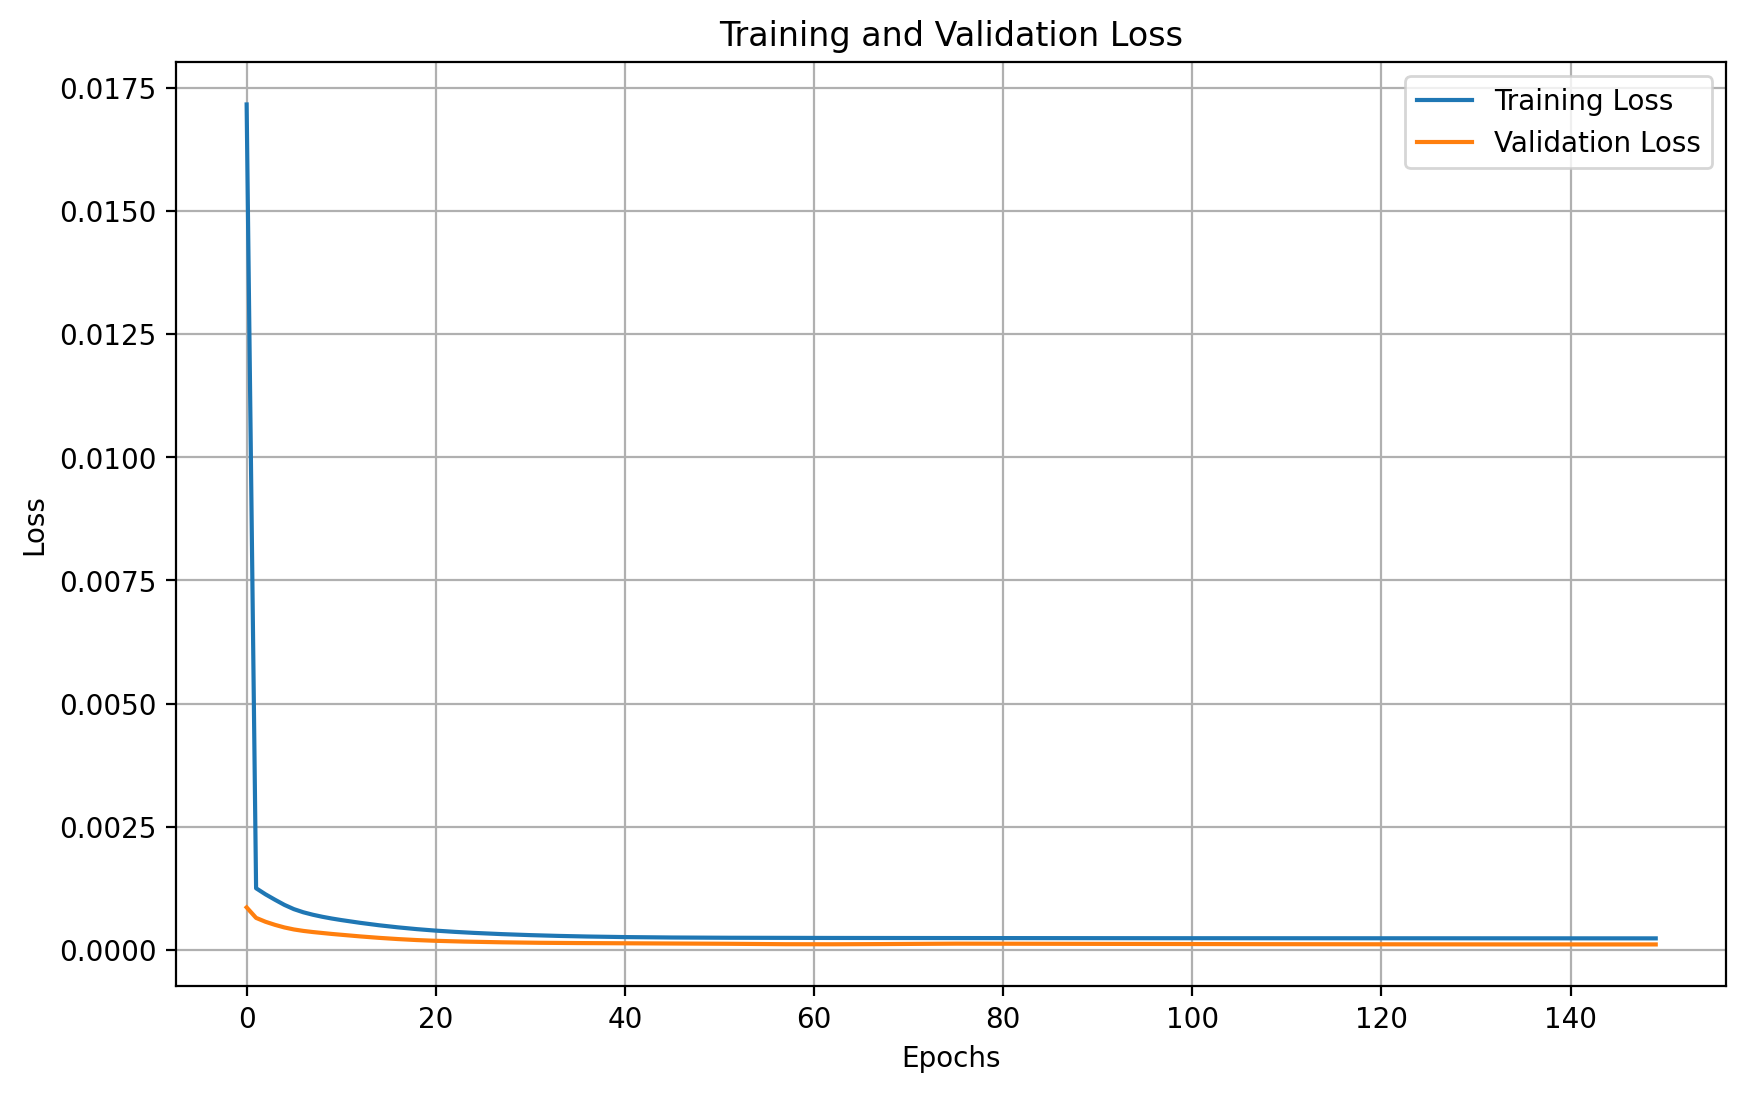

In [ ]:
import matplotlib.pyplot as plt

# Mengambil nilai loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### evaluasi

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Hitung RMSE
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predict))
test_rmse = np.sqrt(mean_squared_error(original_ytest, test_predict))

# Hitung MAPE
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict) * 100  # Mengalikan dengan 100
test_mape = mean_absolute_percentage_error(original_ytest, test_predict) * 100  # Mengalikan dengan 100

# Hitung R² (Koefisien Determinasi)
train_r2 = r2_score(original_ytrain, train_predict)
test_r2 = r2_score(original_ytest, test_predict)

# Cetak hasil evaluasi dengan dua angka di belakang koma
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))

print("Training MAPE (%): {:.4f}".format(train_mape))  # Menampilkan dalam persen
print("Testing MAPE (%): {:.4f}".format(test_mape))    # Menampilkan dalam persen


Training RMSE: 193.4448
Testing RMSE: 136.1692
Training MAPE (%): 0.4132
Testing MAPE (%): 0.3636


# **MODEL5**

## LOAD DATA

In [ ]:
model5_data = pd.read_excel("dataset_lq45_intraday.xlsx", sheet_name="UNVR.JK")

In [ ]:
model5_data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-10-03 09:00:00,4830,4850,4820,4830,4830,3552600
1,2022-10-03 10:00:00,4830,4850,4830,4840,4840,2473400
2,2022-10-03 11:00:00,4840,4850,4840,4840,4840,646800
3,2022-10-03 13:00:00,4840,4850,4840,4840,4840,584800
4,2022-10-03 14:00:00,4840,4870,4840,4850,4850,6528200


## Preprocessing

check null values

In [ ]:
model5_data.isna().sum()

,0
Datetime,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


cek jumlah baris dan kolom

In [ ]:
print('Jumlah total baris yang ada dalam dataset: ', model5_data.shape[0])
print('Jumlah total kolom yang ada dalam dataset: ', model5_data.shape[1])

Jumlah total baris yang ada dalam dataset:  3151
Jumlah total kolom yang ada dalam dataset:  7


In [ ]:
model1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   3152 non-null   datetime64[ns]
 1   Open       3152 non-null   int64         
 2   High       3152 non-null   int64         
 3   Low        3152 non-null   int64         
 4   Close      3152 non-null   int64         
 5   Adj Close  3152 non-null   int64         
 6   Volume     3152 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 172.5 KB


In [ ]:
start_date = model5_data['Datetime'].min()
end_date = model5_data['Datetime'].max()

print('Tanggal mulai dari dataset: ', start_date)
print('Tanggal akhir dari dataset: ', end_date)

Tanggal mulai dari dataset:  2022-10-03 09:00:00
Tanggal akhir dari dataset:  2024-09-27 16:00:00


In [ ]:
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=model5_data['Datetime'],
    y=model5_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Whole period of timeframe of Bank BRI close price 2014-2024',
    xaxis_title='Date',
    yaxis_title='Close Stock',
    plot_bgcolor='black',  # Menyesuaikan warna latar belakang sesuai template dark
    font=dict(size=15, color='white')  # Menyesuaikan warna font sesuai template dark
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()

In [ ]:
filtered_data = model5_data[model5_data['Datetime'].dt.date == pd.to_datetime('2024-09-27').date()]

# Membuat plot untuk satu hari
fig = go.Figure()

# Tambahkan trace untuk plot garis
fig.add_trace(go.Scatter(
    x=filtered_data['Datetime'],
    y=filtered_data['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='orange', width=2)
))

# Update layout
fig.update_layout(
    title='Close Price Bank BRI (1 January 2024)',
    xaxis_title='Time',
    yaxis_title='Close Stock',
    plot_bgcolor='black',
    font=dict(size=15, color='white')
)

# Update sumbu x dan y
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Tampilkan plot
fig.show()


### Normalisasi Data

select features

In [ ]:
model5 =model5_data[['Close']]

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
model5=scaler.fit_transform(np.array(model5).reshape(-1,1))
print(model1.shape)

(3152, 1)


In [ ]:
model5

array([[0.8172043 ],
       [0.8202765 ],
       [0.8202765 ],
       ...,
       [0.03686636],
       [0.03379416],
       [0.03072197]])

### Slicing Training and Test Dataset

In [ ]:
training_size=int(len(model5)*0.80)
test_size=len(model5)-training_size
train_data,test_data=model5[0:training_size,:],model5[training_size:len(model5),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2520, 1)
test_data:  (631, 1)


### reshape array

set seed

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

time step

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 35
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2484, 35)
y_train:  (2484,)
X_test:  (595, 35)
y_test (595,)


reshape input to be [samples, time steps, features] which is required for LSTM


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2484, 35, 1)
X_test:  (595, 35, 1)


## Model Building

In [ ]:
model = Sequential()
model.add(Input(shape=(35, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
# Fit model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=150, batch_size=32, verbose=1,
                    )

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0910 - val_loss: 0.0039
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.7720e-04 - val_loss: 8.5967e-04
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.3643e-04 - val_loss: 6.5353e-04
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.2484e-04 - val_loss: 5.4848e-04
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0952e-04 - val_loss: 4.6591e-04
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.9021e-04 - val_loss: 4.0486e-04
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.6876e-04 - val_loss: 3.6006e-04
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.5055e-04 - val_loss: 3.2729e-04
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.3574e-04 - val_loss: 3.0340e-04
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.2259e-04 - val_loss: 2.8615e-04
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.1025

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((2484, 1), (595, 1))

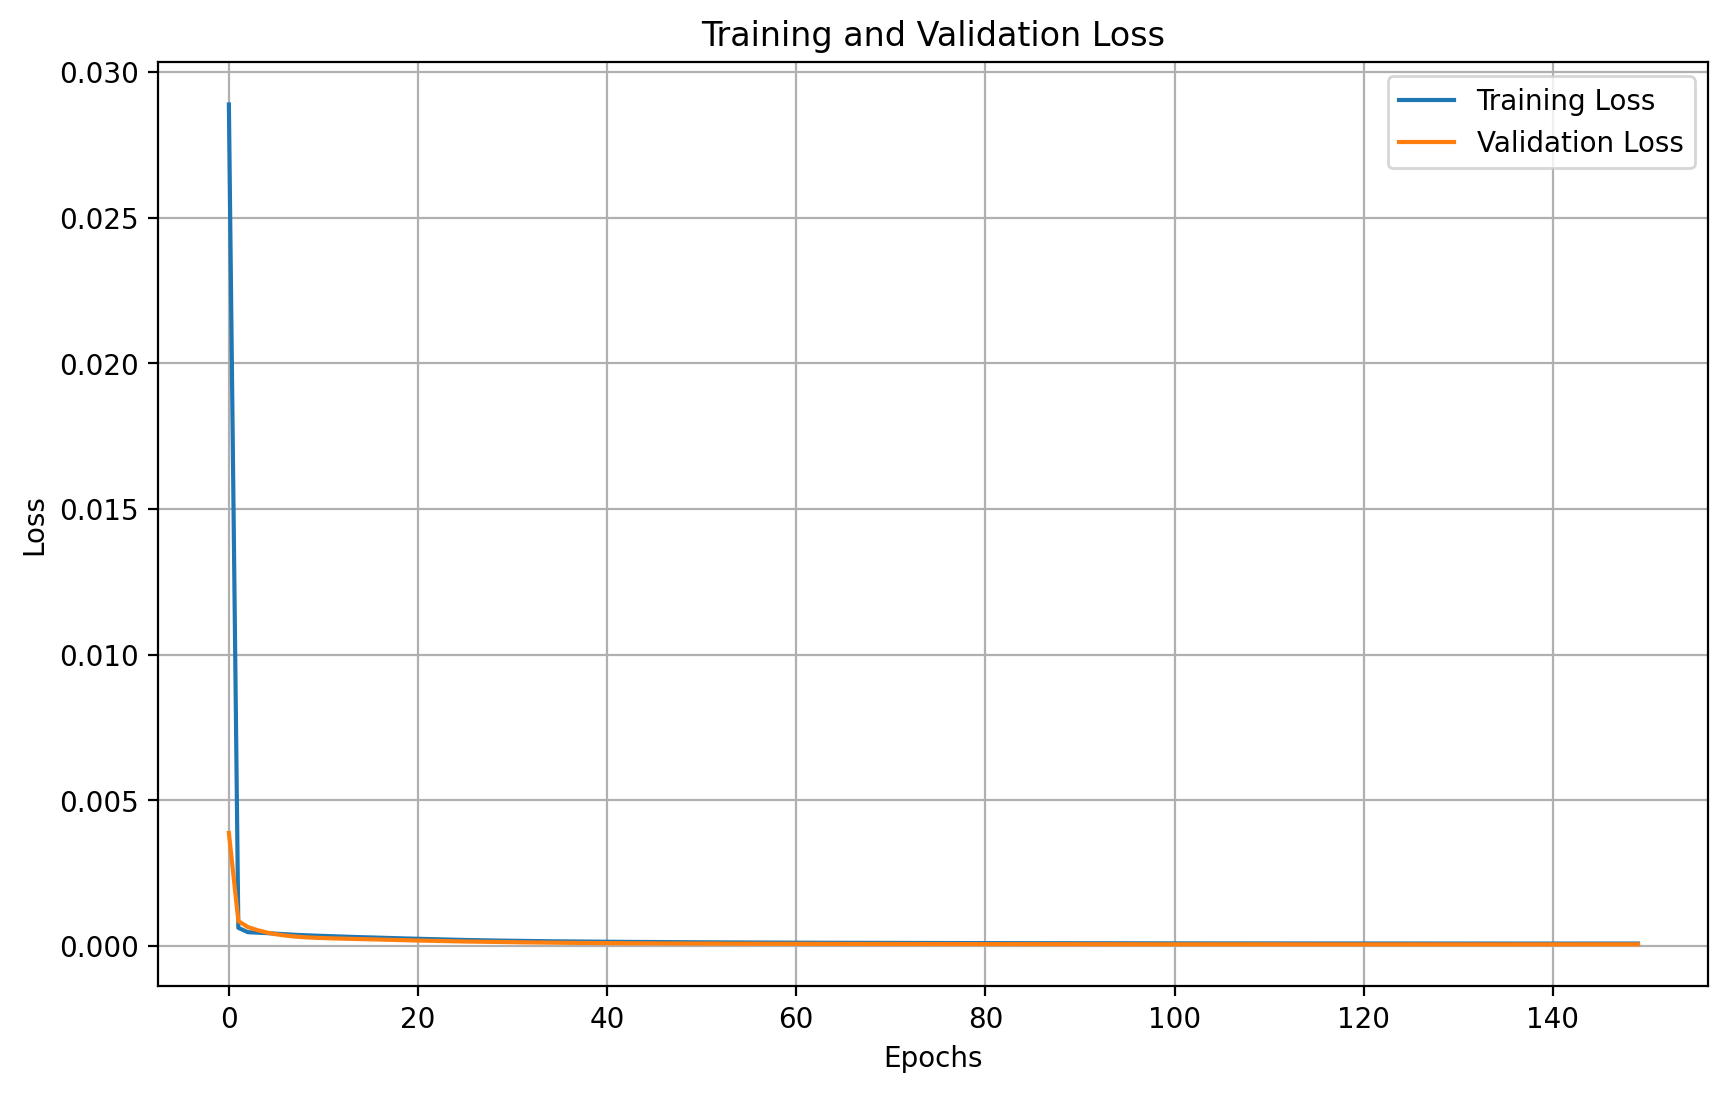

In [ ]:
import matplotlib.pyplot as plt

# Mengambil nilai loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### evaluasi

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Hitung RMSE
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predict))
test_rmse = np.sqrt(mean_squared_error(original_ytest, test_predict))

# Hitung MAPE
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict) * 100  # Mengalikan dengan 100
test_mape = mean_absolute_percentage_error(original_ytest, test_predict) * 100  # Mengalikan dengan 100

# Hitung R² (Koefisien Determinasi)
train_r2 = r2_score(original_ytrain, train_predict)
test_r2 = r2_score(original_ytest, test_predict)

# Cetak hasil evaluasi dengan dua angka di belakang koma
print("Training RMSE: {:.4f}".format(train_rmse))
print("Testing RMSE: {:.4f}".format(test_rmse))

print("Training MAPE (%): {:.4f}".format(train_mape))  # Menampilkan dalam persen
print("Testing MAPE (%): {:.4f}".format(test_mape))    # Menampilkan dalam persen


Training RMSE: 37.5420
Testing RMSE: 25.3351
Training MAPE (%): 0.7212
Testing MAPE (%): 0.5900
